## Feature Extraction by Random Forest

In [1]:
import os 
import sys 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
# Pytorch module 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

import random
from typing import Any, Mapping
from time import gmtime, strftime

# set working directory
os.chdir('/home/jovyan/contrails/contrails_detection/')

# Project Module 
import config
import src.utils as utils
from src.dataset import ContrailsDataset
from src.model import BaseUnet, SegmentLightning
from src.train import Trainer
from src.trainer_lgt import TrainerLightning

In [3]:
from sklearn.model_selection import train_test_split
df = pd.read_csv(config.CSV_FILE, index_col=0)
train_df, valid_df = train_test_split(df[df.Class.isin([0,1])], test_size = .2, random_state=42)
train_df.tail()

,Image_ID,Class
1131,1288917852422534876,1
1295,135845313190230696,1
861,1006793757071532139,0
1460,144592648300779276,0
1127,1101876205139670330,0


### Data Prepration

In [4]:
%%time
torch.manual_seed(111)
transform = transforms.Compose([
    # Add your desired transformations here
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x / 255.0),
    #transforms.Lambda(lambda x: utils.get_rgb(x)), #Ash Color Scheme 
    #transforms.Lambda(lambda x: utils.get_wv_ash(x))
])

train_dataset = ContrailsDataset(dataframe=train_df.sample(1000),
                                 root_dir=config.DATA_DIR+'validation', 
                                 transform=transform, 
                                 sequence_index=config.TS # nth:4 sequence image
                                )

CPU times: user 5.88 ms, sys: 0 ns, total: 5.88 ms
Wall time: 5.84 ms


In [5]:
# Define a function to convert tensors to pandas DataFrame
def tensors_to_dataframe(images, masks):
    data = {'Channel_{}'.format(i): [] for i in range(images[0].shape[0])}  # Assuming images[0] gives shape of one image
    data['Mask'] = []
    
    for image, mask in zip(images, masks):
        # Convert tensors to numpy arrays
        image_np = image.numpy()
        mask_np = mask.numpy()
        
        # Flatten each channel and add to DataFrame
        for i in range(image_np.shape[0]):
            data['Channel_{}'.format(i)].extend(image_np[i].reshape(-1))
        
        # Flatten mask and add to DataFrame
        data['Mask'].extend(mask_np.reshape(-1))
    
    return pd.DataFrame(data)

In [6]:
# Convert dataset images and masks to DataFrame
images = []
masks = []
for i, sample in enumerate(train_dataset):
    image, mask = sample
    images.append(image)
    masks.append(mask)

In [7]:
contr_df = tensors_to_dataframe(images, masks)

In [8]:
contr_df.describe()

,Channel_0,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Mask
count,6.553600e+07,6.553600e+07,6.553600e+07,6.553600e+07,6.553600e+07,6.553600e+07,6.553600e+07,6.553600e+07,6.553600e+07,6.553600e+07
mean,2.569543e-01,3.127211e-01,5.120000e-01,5.120000e-01,5.120000e-01,5.120000e-01,5.120000e-01,5.120000e-01,5.120000e-01,4.859863e-03
std,3.813754e-01,3.641826e-01,3.577709e-01,3.580935e-01,3.577709e-01,3.605785e-01,3.603082e-01,3.582990e-01,3.577709e-01,6.936454e-02
min,7.392612e-01,7.301350e-01,7.327698e-01,7.264584e-01,8.090158e-01,7.268292e-01,7.238594e-01,7.226440e-01,7.326902e-01,0.000000e+00
25%,9.029663e-01,9.346246e-01,9.663337e-01,1.043630e+00,9.732332e-01,1.048864e+00,1.040989e+00,1.029865e+00,9.930940e-01,0.000000e+00
50%,9.185816e-01,9.554283e-01,9.946570e-01,1.102211e+00,1.012286e+00,1.111670e+00,1.108033e+00,1.097881e+00,1.043668e+00,0.000000e+00
75%,9.326942e-01,9.716380e-01,1.011505e+00,1.131103e+00,1.042276e+00,1.143460e+00,1.140199e+00,1.127546e+00,1.066949e+00,0.000000e+00
max,1.069821e+00,1.074434e+00,1.165788e+00,1.267230e+00,1.143719e+00,1.287282e+00,1.294483e+00,1.282759e+00,1.170058e+00,1.000000e+00


In [10]:
contr_df.shape

(65536000, 10)

### Modeling

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [11]:
train_df, valid_df = train_test_split(contr_df, test_size = .2, random_state=44)

In [17]:
train_df.iloc[:, -1].value_counts()

0.0    52174167
1.0      254633
Name: Mask, dtype: int64

In [18]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1] 

In [19]:
X_valid = valid_df.iloc[:, :-1]
y_valid = valid_df.iloc[:, -1] 

In [21]:
%%time
cr_rf_model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0, n_jobs=-1)
cr_rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=200, n_jobs=-1, random_state=0)

In [ ]:
from sklearn.externals import joblib
joblib.dump(cr_rf_model, 'random_forest_model.pkl')

In [22]:
# Make predictions on the validation set
y_pred = cr_rf_model.predict(X_valid)
# Calculate accuracy
cr_accuracy = accuracy_score(y_valid, y_pred)
cr_accuracy

0.9951276397705078

In [25]:
# Generate a classification report
cr_report = classification_report(y_valid, y_pred)
cr_report

'              precision    recall  f1-score   support\n\n         0.0       1.00      1.00      1.00  13043337\n         1.0       0.00      0.00      0.00     63863\n\n    accuracy                           1.00  13107200\n   macro avg       0.50      0.50      0.50  13107200\nweighted avg       0.99      1.00      0.99  13107200\n'

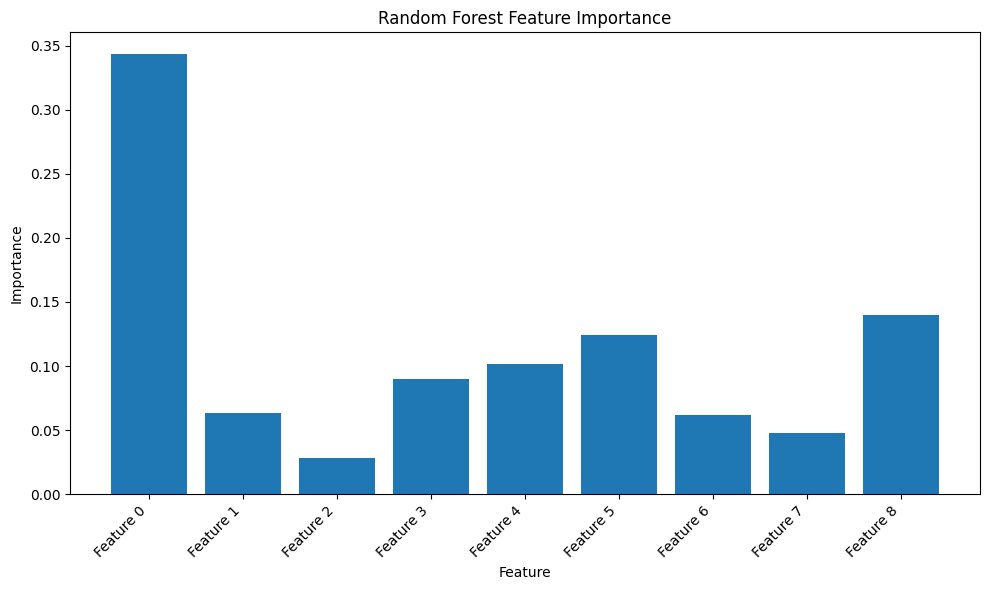

In [26]:
# Plot feature importance
feature_importance = cr_rf_model.feature_importances_
feature_names = [f'Feature {i}' for i in range(len(feature_importance))]

plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()